In [1]:
import numpy as np

In [2]:
OFF = np.genfromtxt(r'/home/drtofa/OneDrive/QTLab2324/DATA ANALYSIS/OPTIMUM/TXT/OFF_Tension.txt')

In [3]:
import matplotlib.pyplot as plt

In [4]:
def FWHM(x,hist):
    halfs = x[np.where(hist < max(hist)/2)]
    mx = max(hist[np.where(hist < max(hist)/2)])
    idx = np.where(hist==max(hist[np.where(hist < max(hist)/2)]))[0]
    return x[idx+1]-x[idx-1]

In [5]:
def plot(OFF, bin_centers,hist, m, func):
    idx = OFF > 0.001
    fig = plt.figure(figsize=(15, 6))
    fig.tight_layout()
    plt.errorbar(bin_centers, hist,np.sqrt(hist+1), alpha=0.5, label='Data', fmt='ko', color='blue')
    plt.errorbar(bin_centers, func(bin_centers,*m.values),np.sqrt(func(bin_centers,*m.values)), fmt='ko',color='black',linestyle='-', label='MIGRAD',alpha=0.8)
    plt.hist(OFF[idx],80,histtype='stepfilled',color='lightblue',density=False,alpha=0.5)
    plt.xlabel('Energy [eV]')
    plt.ylabel('Counts')
    plt.title('OFF Fit')
    plt.grid(True)

    title = []
    for par in m.parameters:
        title.append(
            f"{par} = {m.values[par]:.5f} +/- {m.errors[par]:.5f}"
        )
    title.append(r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof:.2f}")

    # Create the legend
    legend = plt.legend(title="\n".join(title),fontsize=10)

    # Adjust the title's font size
    legend.get_title().set_fontsize(10)  # or use a numeric value like 8

In [6]:
amp = OFF[np.where(OFF > 0.001)[0]]

In [43]:
#q25, q75 = np.percentile(amp, [25, 75])
#bin_width = 2 * (q75 - q25) / np.cbrt(len(amp))
#bins = int((amp.max() - amp.min()) / bin_width)
bins = int(np.sqrt(amp.shape[0]))
hist, bin_edges = np.histogram(amp, bins=bins, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

In [44]:
from scipy.signal import find_peaks

In [45]:
ppos, pprop = find_peaks(hist,0)

In [158]:
x = bin_centers

In [193]:
from scipy.special import factorial


def compute_sum_poisson_gaussian_3(amplitudes, A, mu, b, d, sigma):
    """
    Compute the sum over n of P(n; µ)·G(OFF-nb)
    
    Parameters:
    - amplitudes: Array of measured amplitudes (OFF).
    - N: Maximum number of photons to consider.
    - mu: Mean of the Poisson distribution.
    - b: Conversion from amplitudes to eV
    - sigma: Standard deviation of the Gaussian distribution.
    
    Returns:
    - Array of computed values for the given amplitudes.
    """
    # Initialize result array
    result = np.zeros_like(amplitudes)
    
    # Compute the Gaussian PDF for each photon number and sum up
    for n in range(N):
        # Compute Gaussian PDF for the current number of photons
        values = (pow(mu,n)*np.exp(-mu)/factorial(n)) * np.exp(-((amplitudes-b*n-d)**2)/(2*sigma**2))
        
        # Update result array
        result += values
    
    return A * result

In [382]:
#b = 9/0.002
mu    = 4
N     = int(mu + 3 * np.sqrt(mu))
A     = 1000
b     = 0.0001
sigma = 0.00004
d     = 0.0011
p     = [A, mu, b, d, sigma]

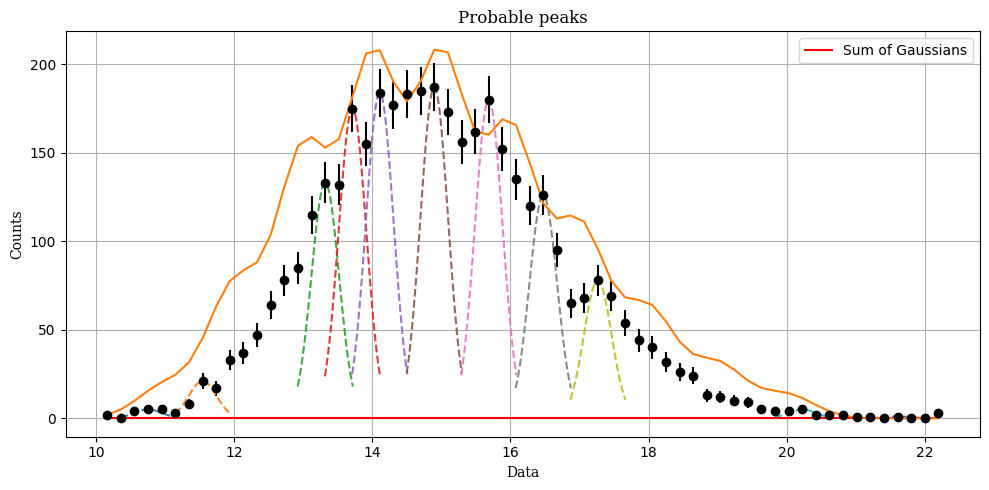

In [383]:
from scipy.special import factorial

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()
#plt.hist(amp,bins,density=False,histtype='step',alpha=0.8,color='black')
val = 0
bs = 0.1*b
temps = np.linspace(min(x), max(x), 1000)
total_vals = np.zeros_like(temps)
t = x/b
plt.errorbar(t,hist,np.sqrt(hist),fmt='ko')

# Loop over positions and plot individual Gaussians
for n,pos in enumerate(ppos):
    temp = np.linspace(x[pos] - 4*bs, x[pos] + 4*bs, 100)
    vals = gauss(temp, hist[pos], x[pos], 2*bs )
    
    # Plot each Gaussian
    plt.plot(temp/b, vals, alpha=0.9, linestyle='--')
    # Accumulate the Gaussian values

# Plot the sum of Gaussians
plt.plot(np.array(temps)/b, total_vals, color='red', label='Sum of Gaussians')
plt.plot(t, compute_sum_poisson_gaussian_3(x,*p))
# Labels and aesthetics
plt.xlabel('Data',fontfamily='serif')
plt.ylabel('Counts',fontfamily='serif')
plt.legend()
plt.grid()
plt.title('Probable peaks',fontfamily='serif')
plt.tight_layout()  # Move this here, after all plotting is done

In [384]:
from iminuit import minuit
from iminuit.cost import LeastSquares

In [393]:
lsq = LeastSquares(x,hist,np.sqrt(hist+1),compute_sum_poisson_gaussian_3)
m = minuit.Minuit(lsq, *p)
m.fixed['b'] = True
#m.limits['d'] = (d*0.95,d*1.05)
#m.limits['mu']   = (7,np.inf)
m.limits['sigma']   = (0,10*m.values['b'])
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 44.4 (χ²/ndof = 0.8)       │              Nfcn = 177              │
│ EDM = 3.62e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │    316    │    30     │            │            │         │         │       │
│ 1 │ mu    │   1.84    │   0.20    │            │            │         │         │       │
│ 2 │ b     │  100e-6   │   1e-6    │            │            │         │         │  yes  │
│ 3 │ d     │ 1.318e-3  │ 0.020e-3  │            │            │         │         │       │
│ 4 │ sigma │   96e-6   │   9e-6    │            │            │    0    │  0.001  │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────────────────────┐
│       │             A            mu             b             d         sigma │
├───────┼───────────────────────────────────────────────────────────────────────┤
│     A │           916          5.64             0  -558.0671e-6 -271.13680e-6 │
│    mu │          5.64        0.0402          0.00    -3.9243e-6   -1.71714e-6 │
│     b │             0          0.00             0             0             0 │
│     d │  -558.0671e-6    -3.9243e-6             0      3.91e-10       0.17e-9 │
│ sigma │ -271.13680e-6   -1.71714e-6             0       0.17e-9      8.26e-11 │
└───────┴───────────────────────────────────────────────────────────────────────┘

In [394]:
x_final = (x-m.values['d'])/m.values['b']

Text(0.5, 1.0, 'FINAL FIT')

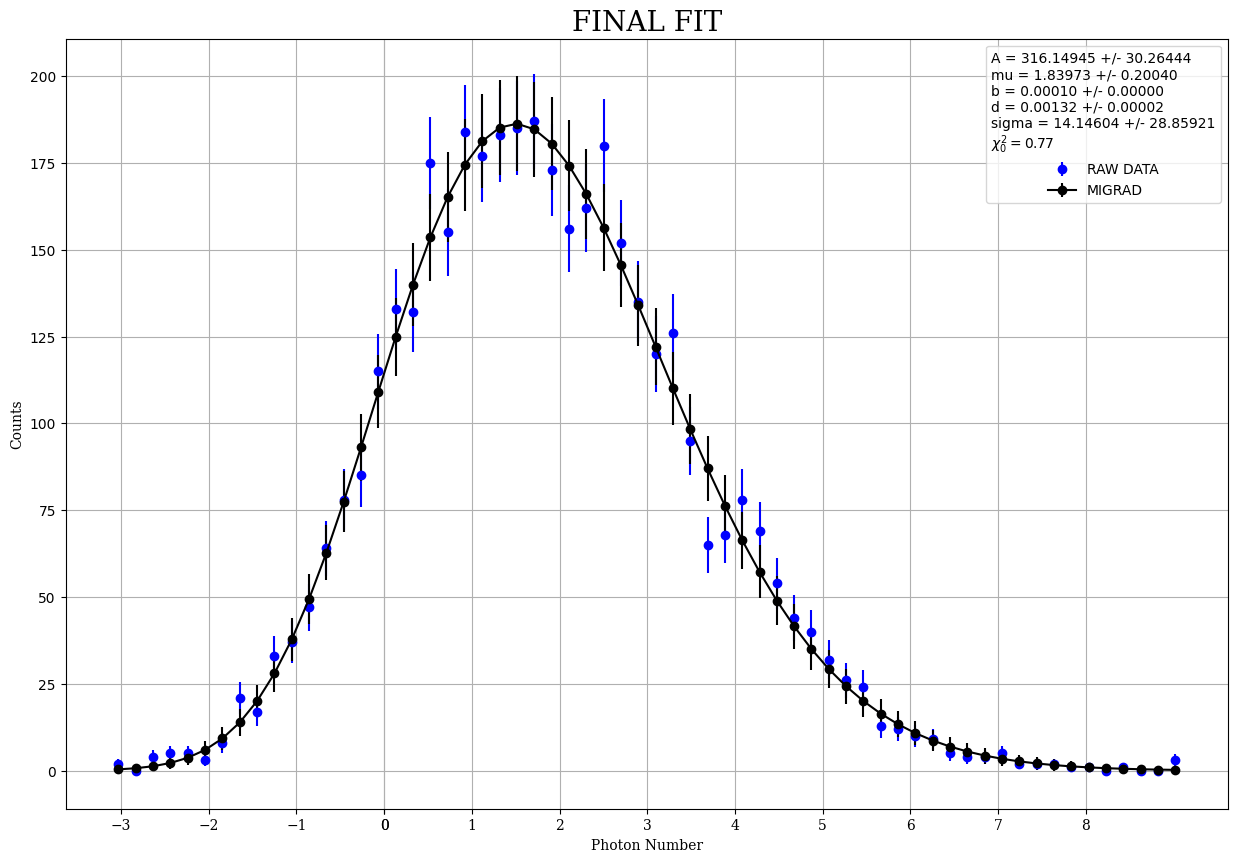

In [395]:
fig = plt.figure(figsize=(15, 10))
fig.tight_layout()
plt.errorbar(x_final,hist,np.sqrt(hist),fmt='bo',label='RAW DATA')
#plt.hist(amp,bins,density=False,histtype='stepfilled',alpha=0.2,color='lightblue')
plt.errorbar(x_final,compute_sum_poisson_gaussian_3(x,*m.values),np.sqrt(compute_sum_poisson_gaussian_3(x,*m.values)+1),fmt='ko-',label='MIGRAD')
plt.xlabel('Photon Number', fontsize=10, fontfamily='serif')
plt.ylabel('Counts', fontsize=10, fontfamily='serif')
plt.legend()
plt.grid()

numbers = np.arange(min(x_final),max(x_final),1)
ticks = []
for n in x_final[::5]:
    #plt.axvline(int(n),0,1,linestyle='--',alpha=0.4,color='red')
    ticks.append(int(n))

title = []
for par in m.parameters:
    if 'sigma' in par:
        title.append(
        f"{par} = {(m.values[par]+m.values['d'])/m.values['b']:.5f} +/- {(m.errors[par]+m.errors['d'])/m.errors['b']:.5f}"
    )
    else:
        title.append(
            f"{par} = {m.values[par]:.5f} +/- {m.errors[par]:.5f}"
        )
    

title.append(r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof:.2f}")

# Create the legend
legend = plt.legend(title="\n".join(title),fontsize=10)
plt.xticks(ticks,fontsize=10,fontfamily='serif',rotation=0)
#plt.set_yticksfont('serif')
#plt.yticks(compute_sum_poisson_gaussian_3(x,*m.values)[::10],fontsize=10,fontfamily='serif',rotation=45)
# Adjust the title's font size
legend.get_title().set_fontsize(10)  # or use a numeric value like 8
plt.title('FINAL FIT',fontsize=20,fontfamily='serif')